
                                               --- STARTING KHPS2 ANALYSIS ---                                               
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.7018e-03                                    9.27e-03    
       1              2         8.4825e-03      2.19e-04       3.97e-01       5.72e-04    
       2              3         8.4024e-03      8.01e-05       5.49e-01       2.42e-04    
       3              4         8.3956e-03      6.77e-06       7.86e-02       2.38e-04    
       4              5         8.3929e-03      2.74e-06       3.58e-02       9.49e-05    
       5              6         8.3928e-03      5.88e-08       5.03e-03       9.70e-06    
       6              7         8.3928e-03      5.57e-09       1.14e-03       2.87e-06    
       7              8         8.3928e-03      1.11e-10       2.25e-04       3.86e-07    
       8              9         8.3928e-03      4.60e-

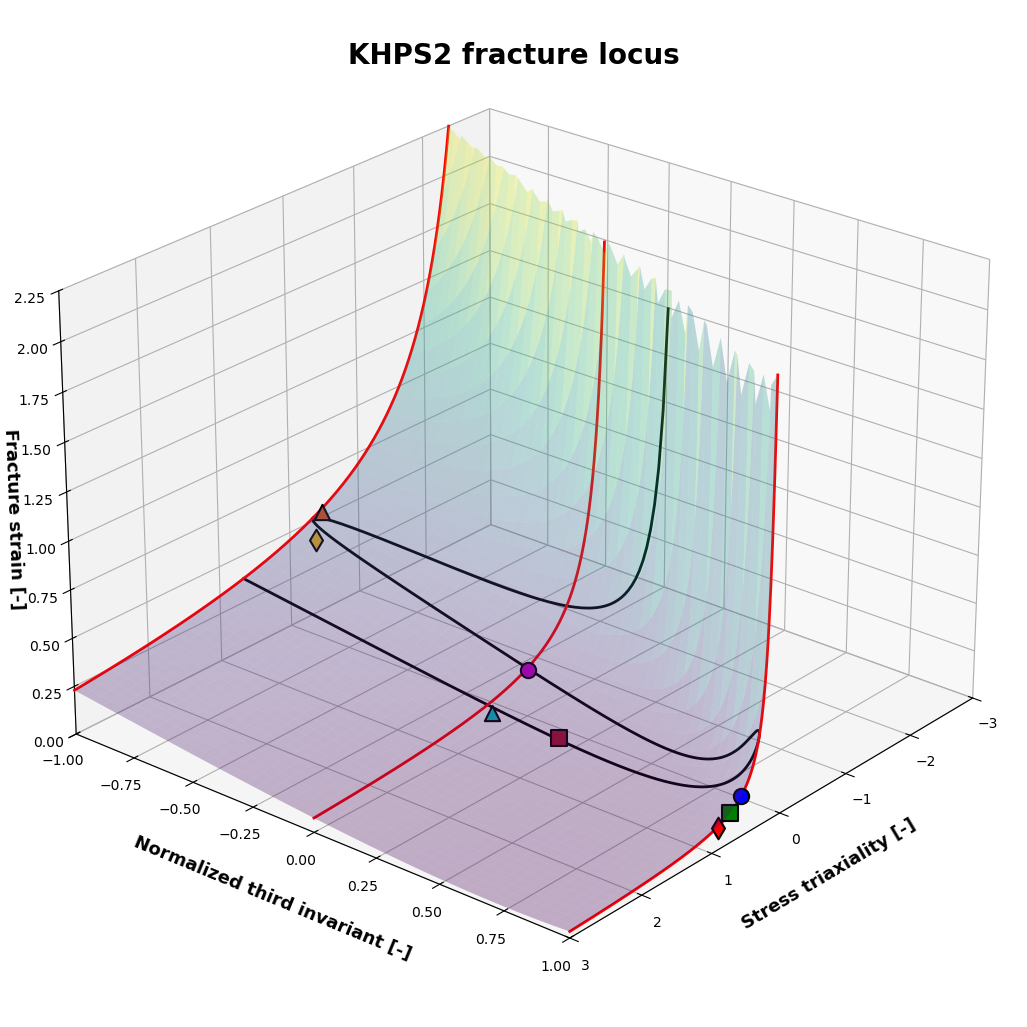


--------------------------------------------------------  Results  --------------------------------------------------------
Calibrated material parameters:	G1: -0.12579,	G2: 1.24632,	G3: 3.00000,	G4: 0.09386,	G5: 1.37916,	G6: 0.31364

Fracture strain difference between each calibration point and the locus:
[ 0.00070685  0.00141644 -0.003631   -0.00751148 -0.00684845  0.0107486
 -0.08825405  0.09360721]

Percentage calibration errors for each specimen:
[ 0.34313135  0.92578069  3.15739471  4.87758371  2.80674326  8.08165269
 21.16404117 15.91959314]

Total percentage error: 57.27592%

                                                  --- ANALYSIS COMPLETE ---                                                  



In [1]:
    # Standard library import
import numpy as np
import logging
    # Custom package import
from package.Main_workflow import run_khps2_analysis

# ---------------------------------------------------------------------------------------------------------------------
#                                                  INPUTS
# ---------------------------------------------------------------------------------------------------------------------
    # Definition of aproximation points (measured values of each specimen) - Input for the KHPS2_function
        # Format: {specimen_name: [Fracture strain, Stress triaxiality, Normalized third invariant]}
specimen_data = {"specimen1": [0.206, 0.583, 1],                   
                 "specimen2": [0.153, 0.745, 1],
                 "specimen3": [0.115, 0.917, 1],
                 "specimen4": [0.154, 0.623, 0.031],
                 "specimen5": [0.244, 0.001, 0.003],
                 "specimen6": [0.133, 0.543, 0.279],
                 "specimen7": [0.417, -0.295, -0.975],
                 "specimen8": [0.588, -0.270, -0.942]}

    # Initial estimated material parameters G1,... G6 (unknown - investigated values)
initial_G = np.array([-0.15, 1.15, 2.12, 0.09, 0.94, 0.28])

    # Lower and upper boundaries of the investigated G1,... G6 material parameters
lower_bounds = np.array([-1, 0, 0, 0, 0, 0])
upper_bounds = np.array([2, 2, 3, 2, 2, 2])

# ---------------------------------------------------------------------------------------------------------------------
#                                                  CONFIGURATION
# ---------------------------------------------------------------------------------------------------------------------
    # scipy.optimize.least_squares option inputs
optimization_options = {
    'ftol': 1e-8,                  # Tolerance for the change in the sum of squares of residuals.
    'xtol': 1e-8,                  # Tolerance for the change in the optimization variables (G parameters).
    'max_nfev': 10000,             # Maximum number of function evaluations.
    'verbose': 2}                  # Display iteration output: 0 (silent), 1 (final report), 2 (each iteration).

    # Numerical stability constant for prevention of division by zero
denominator_epsilon = 1e-6

    # Figure setting
figure_size = (13, 13.5)                        # Size of the figure (Width, Height)
view_elev = 25                                  # Vertical view rotation of the figure (Elevation)
view_azim = 40                                  # Side view rotation of the figure
x_lim = [-3, 3]                                 # x axis limit
y_lim = [-1, 1]                                 # y axis limit
z_lim = [0, 2.25]                               # z axis limit
x_label = 'Stress triaxiality [-]'              # x axis label
y_label = 'Normalized third invariant [-]'      # y axis label
z_label = 'Fracture strain [-]'                 # z axis label
plot_title = 'KHPS2 fracture locus'             # Plot title
labelpad_x = 15                                 # x axis padding
labelpad_y = 15                                 # y axis padding
labelpad_z = 1                                  # z axis padding
title_y_position = 1.02                         # Title z axis padding
label_font_size = 13                            # Label font size
title_font_size = 20                            # Title font size

    # Main surface setting
surface_alpha = 0.3                                      # Transparency of the main surface
surface_rgb_color = np.array([0.3010, 0.7450, 0.9330])   # Color of the main surface

    # Plane stress curve setting
plot_plane_stress_curve = True                           # Enable/Disable plotting of the plane stress curve
plane_stress_line_color = 'k'                            # Color of the plane stress curve
plane_stress_line_width = 2                              # Line width of the plane stress curve

    # Constant invariant cuvse setting
plot_constant_invariant_curves = True                    # Enable/Disable plotting of the constant invariant curves
constant_invariant_line_color = 'r'                      # Color of the constant invariant curve
constant_invariant_line_width = 2                        # Line width of the constant invariant curve

    # Approximated point setting
plot_approximated_points = True                          # Enable/Disable plotting of the approximation points
marker_styles = ['o', 's', 'd', '^',                     # Marker symbols
                 'o', 's', 'd', '^']
marker_size_area = 121                                   # Marker size
marker_face_colors = [                                   # Marker color
    [0, 0, 1],                     # specimen1: Blue
    [0, 0.5, 0],                   # specimen2: Green
    [1, 0, 0],                     # specimen3: Red
    [0, 0.75, 0.75],               # specimen4: Teal
    [0.75, 0, 0.75],               # specimen5: Purple
    [0.6350, 0.0780, 0.1840],      # specimen6: brown-red
    [0.9290, 0.6940, 0.1250],      # specimen7: yellow-orange
    [0.8500, 0.3250, 0.0980]]      # specimen8: orange-brown
marker_edge_color = 'k'                                   # Marker's edge color
marker_edge_linewidth = 1.5                               # Marker's edge linewidth

    # Cut-off plane setting
plot_cut_off_plane = False                                # Enable/Disable plotting of the cut-off plane
cut_off_plane_color = np.array([0.4940, 0.1840, 0.5560])  # Color of the cut-off plane
cut_off_plane_alpha = 0.5                                 # Transparency of the cut-off plane

# ---------------------------------------------------------------------------------------------------------------------
#                                                  EXECUTION
# ---------------------------------------------------------------------------------------------------------------------

plotting_options = {
    'figure_size': figure_size,
    'view_elev': view_elev,
    'view_azim': view_azim,
    'surface_alpha': surface_alpha,
    'surface_rgb_color': surface_rgb_color,
    'plane_stress_line_color': plane_stress_line_color,
    'plane_stress_line_width': plane_stress_line_width,
    'constant_invariant_line_color': constant_invariant_line_color,
    'constant_invariant_line_width': constant_invariant_line_width,
    'marker_styles': marker_styles,
    'marker_size_area': marker_size_area,
    'marker_face_colors': marker_face_colors,
    'marker_edge_color': marker_edge_color,
    'marker_edge_linewidth': marker_edge_linewidth,
    'x_lim': x_lim,
    'y_lim': y_lim,
    'z_lim': z_lim,
    'x_label': x_label,
    'y_label': y_label,
    'z_label': z_label,
    'plot_title': plot_title,
    'labelpad_x': labelpad_x,
    'labelpad_y': labelpad_y,
    'labelpad_z': labelpad_z,
    'title_y_position': title_y_position,
    'label_font_size': label_font_size,
    'title_font_size': title_font_size,
    'plot_cut_off_plane': plot_cut_off_plane,
    'cut_off_plane_color': cut_off_plane_color,
    'cut_off_plane_alpha': cut_off_plane_alpha,
    'plot_approximated_points': plot_approximated_points,
    'plot_constant_invariant_curves': plot_constant_invariant_curves,
    'plot_plane_stress_curve': plot_plane_stress_curve}

print("\n" + "=" * 125)
print(f"{'--- STARTING KHPS2 ANALYSIS ---':^125}")
print("=" * 125)

# Full pipeline execution
results = run_khps2_analysis(
    specimen_data, initial_G, lower_bounds, upper_bounds,
    optimization_options, denominator_epsilon, z_lim,
    plotting_options)

# Result unpacking
G1, G2, G3, G4, G5, G6 = results['final_G_params']           # Calibrated material parameters
total_abs_difference = results['total_abs_difference']       # Total calibration error (Sum of calibration errors)
p_calibration_error = results['p_calibration_error']         # Calibration error in percentages for each specimen
pt_calibration_error = results['pt_calibration_error']       # Total (Sum) calibration error in percentages
ef_r = results['ef_r']                                       # Calibration error - difference between calibration points and the calibrated locus

# Result report
print("\n" + "-" * 56 + "  Results  " + "-" * 56 + "")
print(f"Calibrated material parameters:\tG1: {G1:7.5f},\tG2: {G2:7.5f},\tG3: {G3:7.5f},\tG4: {G4:7.5f},\tG5: {G5:7.5f},\tG6: {G6:7.5f}\n")
print(f"Fracture strain difference between each calibration point and the locus:\n{ef_r}\n")
print(f"Percentage calibration errors for each specimen:\n{p_calibration_error}\n")
print(f"Total percentage error: {pt_calibration_error:.5f}%\n")
print("=" * 125)
print(f"{'--- ANALYSIS COMPLETE ---':^125}")
print("=" * 125 + "\n")
